In [183]:
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import os
import glob
from PIL import Image
import numpy as np 
from torchvision.utils import save_image
import torchvision
from torchvision import transforms
import PIL

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH_DIR = "stuff/data/input/"
EXPECTED_RESULTS = "stuff/data/Peihao_result/"
SAVING_DIR = 'stuff/results/improved_embedding/'
PCA_DIR = "stuff/data/pca/"

In [3]:
DEVICE

device(type='cuda', index=0)

In [4]:
%cd ../
!ls

/workspace
Dockerfile  docker_run.sh    notebooks		stuff	     utils
README.md   environment.yml  optimizer.py	test.py
dnnlib	    model	     pca_components.py	torch_utils


In [5]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module-
    G.mapping.num_ws = 1 # setting to the space w not w+ that was defined by deafault

In [6]:
#@title Function to load data from a folder
def load_data(directory, interval = None):

  if interval is None:
    files = sorted(glob.glob(os.path.join(directory + "*.png")))
  else:
    files = sorted(np.array(glob.glob(os.path.join(directory + "*.png")))[interval])

  data = {}
  for idx, file in enumerate(files):
    img_dir = {
        # "img": lpips.load_image(file),
        "img": Image.open(file),
        "name": os.path.basename(os.path.normpath(file))
    }
    data[idx] = img_dir
  return data

In [7]:
#@title Function to display the data
def display_data(data, ncols=4):

    inches = 4
    num_img = len(data)
    nrows = np.ceil(num_img/ncols).astype(int)
    fig, axs = plt.subplots(nrows,ncols,figsize=(inches * ncols , inches * nrows))

    idx = 0
    for i in range(nrows):
      for j in range(ncols):
        if idx < num_img:
          axs[i,j].imshow(data[idx]['img'])
          axs[i,j].set_title("Image ID: {}".format(idx))
          axs[i,j].axis('off')
          idx += 1


In [8]:
data = load_data(PATH_DIR, np.r_[0:12])

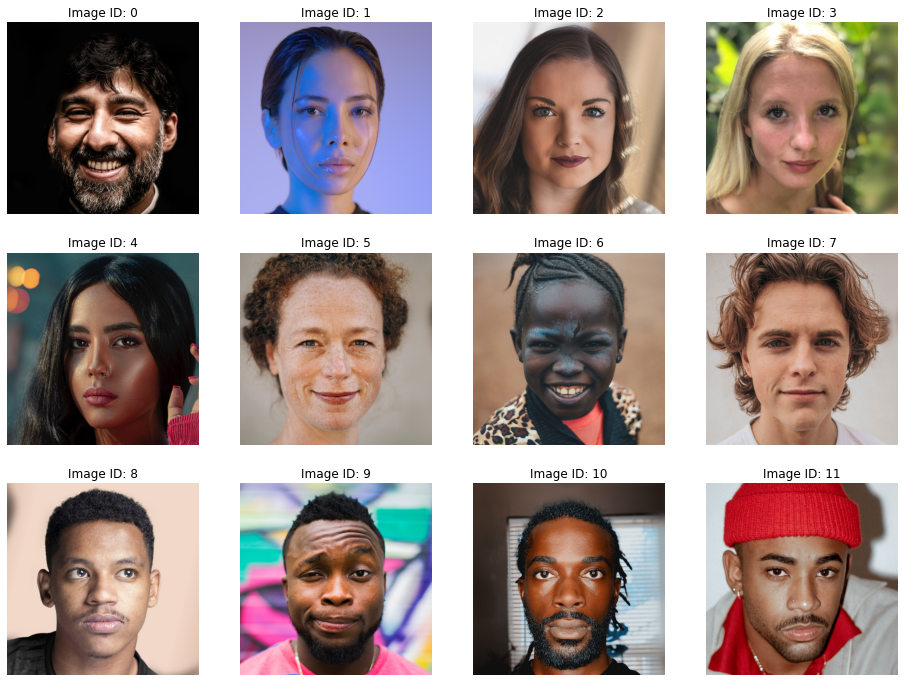

In [9]:
display_data(data)

In [10]:
#@title Function to load latents
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [127]:
#@title Function to plot the synthetic image per iterations

def show_images_results(data, id, generator, latents_file, iterations_to_show, subfix = "", expected_result = False, save = False, save_last = False):

    latent_codes = load_latents(latents_file)
    base_names_list = latents_file.split(".")
    base_name = '.'.join(base_names_list[:-1])

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    if expected_result: n_images += 1
    fig, axs = plt.subplots(1,n_images ,figsize=(inches * n_images , inches))

    # original image
    axs[0].imshow(data[id]['img'])
    axs[0].set_title('Original')
    axs[0].axis('off')

    # embeddings per iterations
    idx = 1
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = generator.synthesis(tensor_latent, noise_mode='const')
        # max_img = torch.max(synth_img)
        # min_img = torch.min(synth_img)
        # synth_img = (synth_img - min_img) / (max_img - min_img)
        synth_img = (synth_img + 1) / 2
        
        if save_last and iter == iterations_to_show[-1]:
          print("Saving last image...")
          save_image(synth_img.clamp(0,1), os.path.join(SAVING_DIR,"images/last_generated/{}.png".format(base_name)))

        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')



        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    # expected result
    if expected_result:
      with open(EXPECTED_RESULTS + data[id]['name'],"rb") as f:
          image=Image.open(f)
          axs[idx].imshow(image)
          axs[idx].set_title('Expected Result')
          axs[idx].axis('off')

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}{}.svg".format(
          base_name,
          subfix))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)


In [149]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = {idx: f for idx, f in enumerate(latents_files) if ".npz" in f}
latents_files

{0: 'aatik-tasneem-7omHUGhhmZ0-unsplash_colorization_lambda_0.001_latents_iters_002000_step_0100_w_mean.npz',
 1: 'aatik-tasneem-7omHUGhhmZ0-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 2: 'aatik-tasneem-7omHUGhhmZ0-unsplash_colorization_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 3: 'aatik-tasneem-7omHUGhhmZ0-unsplash_inpainting_lambda_0.001_latents_iters_002000_step_0100_w_mean.npz',
 4: 'aatik-tasneem-7omHUGhhmZ0-unsplash_inpainting_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 5: 'aatik-tasneem-7omHUGhhmZ0-unsplash_inpainting_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 6: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_lambda_0.001_latents_iters_002000_step_0100_w_mean.npz',
 7: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 8: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 9: 'aatik-tasneem-7omHUG

In [232]:
aux_latents = [ f for idx, f in latents_files.items() if "0.005" in f and "colorization" in f]
aux_latents

['aatik-tasneem-7omHUGhhmZ0-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'aiony-haust-3TLl_97HNJo-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'aleksandr-minakov-xDyqR14KyAs-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'alex-lee-l7oI8wCfQ8Y-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'amin-rk-QKxRH1sAfYY-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'andrew-heald-z2wyh1Maq8E-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'annie-spratt-ZyWN6N41JUc-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'austin-wade-X6Uj51n5CE8-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'awab-husameldin-678MnkzVdRU-unsplash_colorization_lambda_0.005_latents_iters_002000_step_0100_w_mean.npz',
 'ayo-ogunseinde-sibVwORYqs0-unsplash_colorizati

Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...


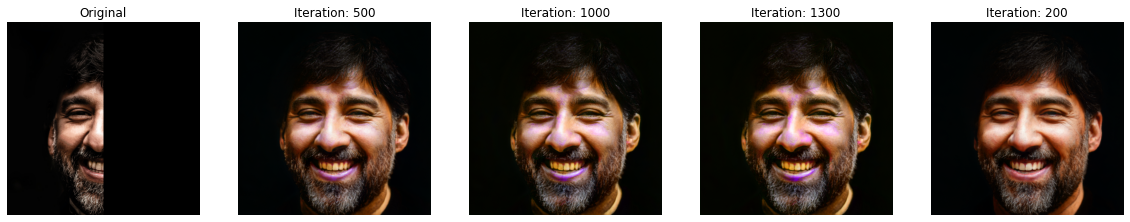

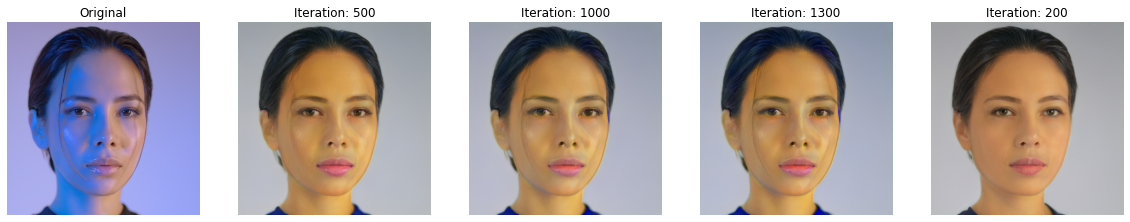

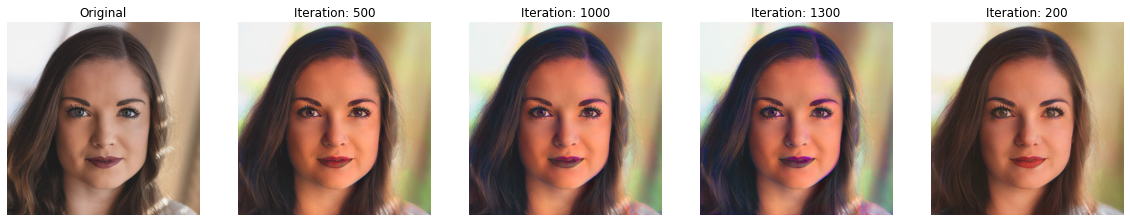

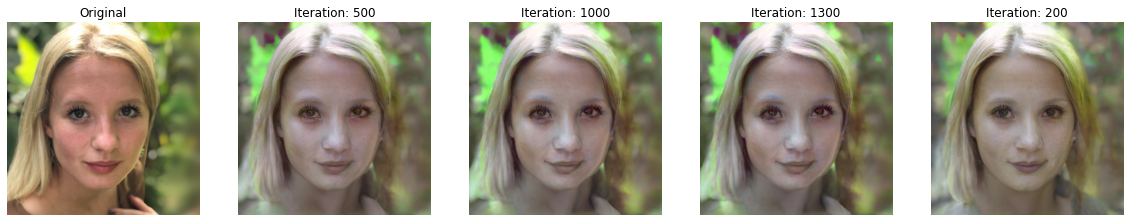

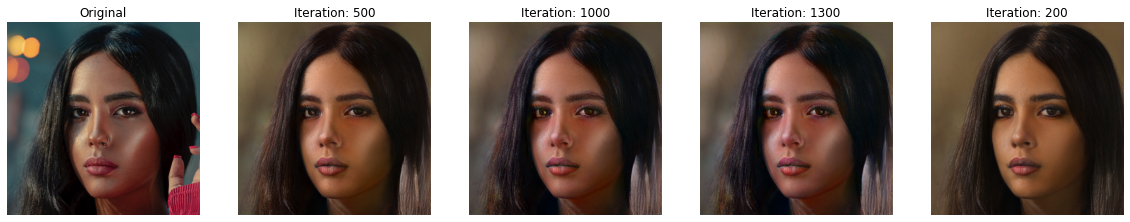

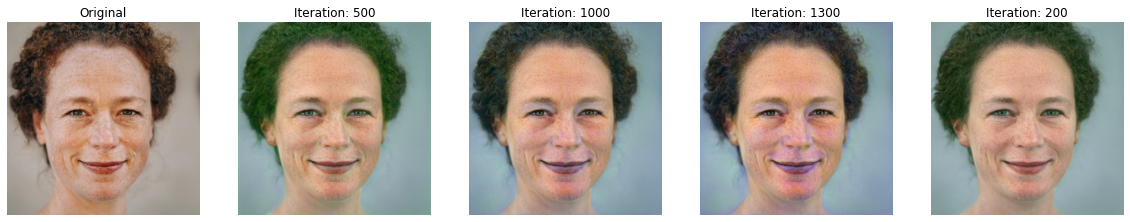

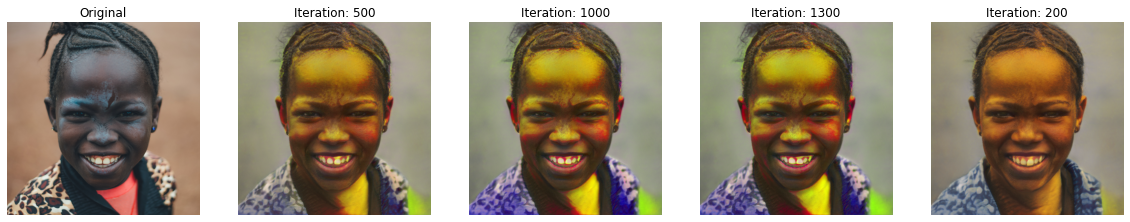

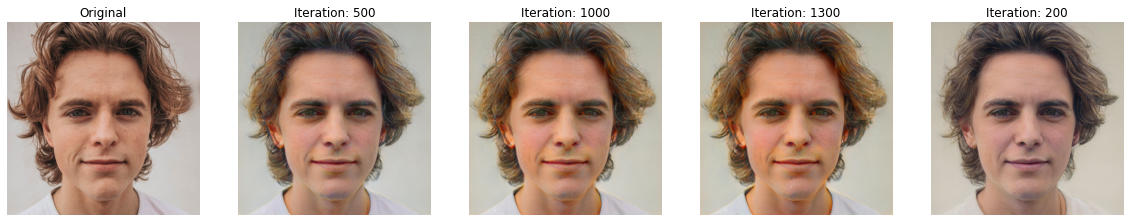

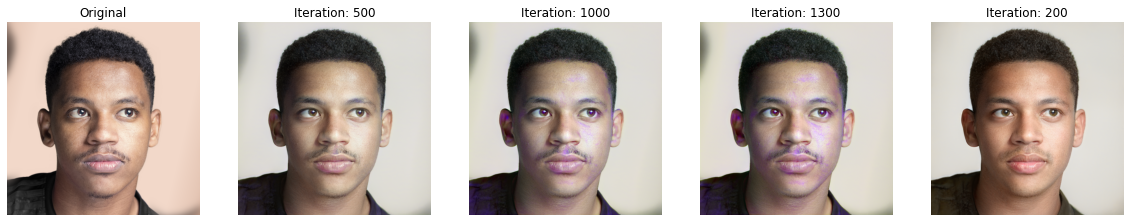

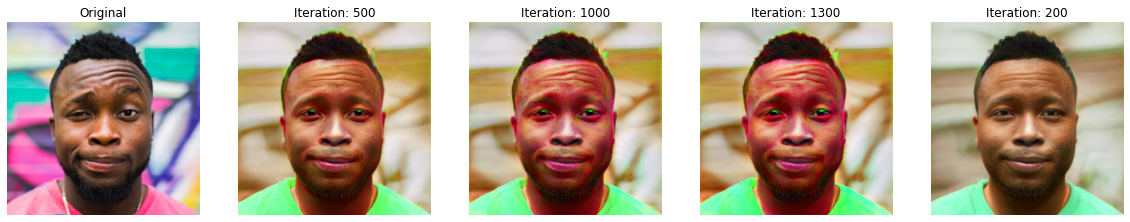

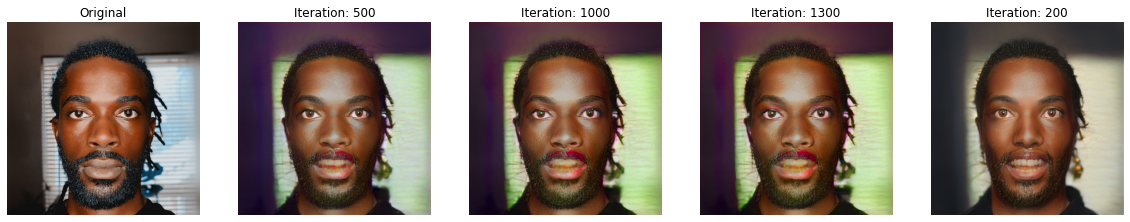

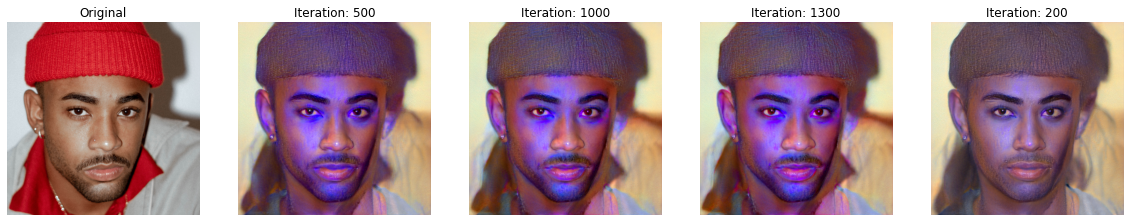

In [233]:
for i in range(len(aux_latents)):
    show_images_results(data, i, G, aux_latents[i], [500, 1000, 1300, 200],expected_result = False, save_last=True)

In [134]:
aux_latents = [ f for idx, f in latents_files.items() if "0.01" in f and "only_embed" in f]
aux_latents

['aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'aiony-haust-3TLl_97HNJo-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'aleksandr-minakov-xDyqR14KyAs-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'alex-lee-l7oI8wCfQ8Y-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'amin-rk-QKxRH1sAfYY-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'andrew-heald-z2wyh1Maq8E-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'annie-spratt-ZyWN6N41JUc-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'austin-wade-X6Uj51n5CE8-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'awab-husameldin-678MnkzVdRU-unsplash_only_embed_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz',
 'ayo-ogunseinde-sibVwORYqs0-unsplash_only_embed_lambda_0.01_latents_iters_

In [171]:
def convert2grayscale(input_img):
  transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3)                        
  ])

  return transform(input_img)

In [198]:
latents = load_latents('aleksandr-minakov-xDyqR14KyAs-unsplash_colorization_lambda_0.01_latents_iters_002000_step_0100_w_mean.npz')
code = torch.tensor(latents['1300']).to(DEVICE)

In [202]:
synth_img = G.synthesis(code, noise_mode='const')
#synth_img = (synth_img + 1) / 2

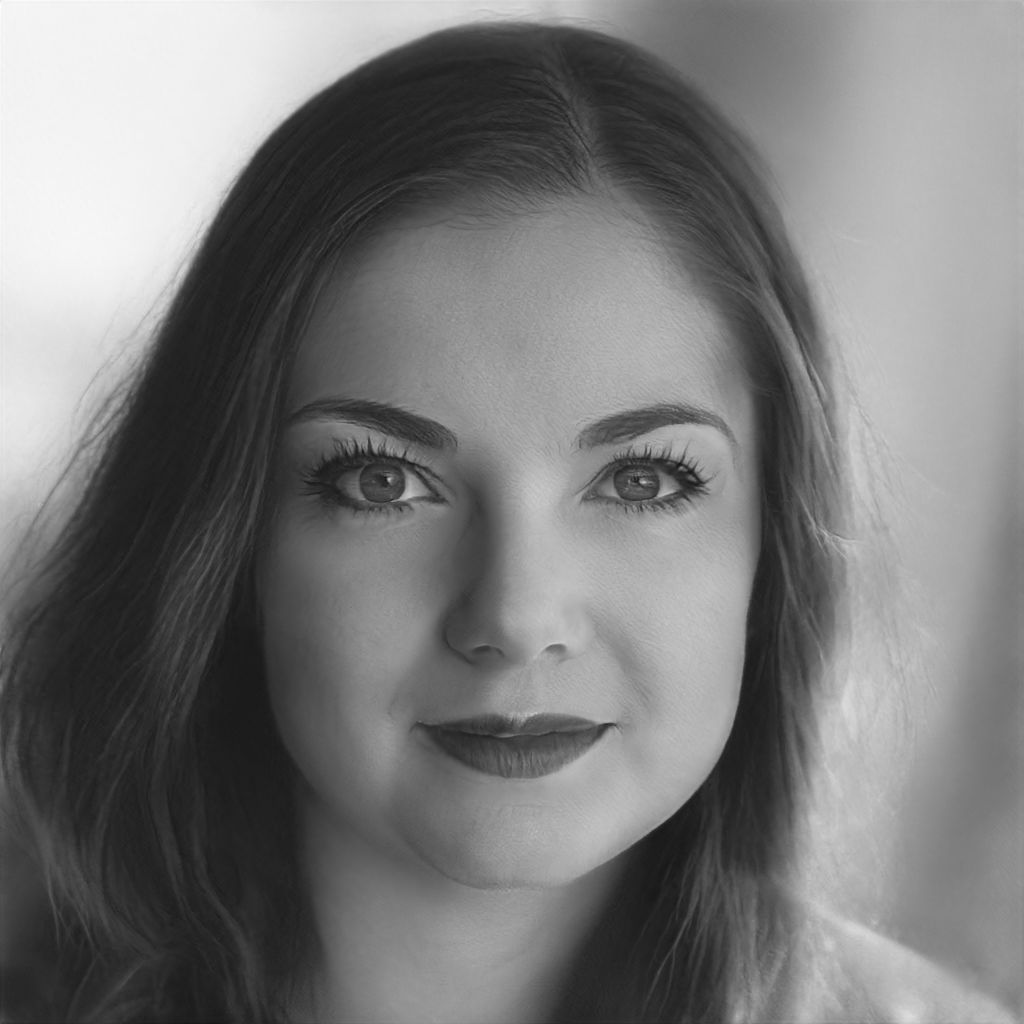

In [203]:
togray = convert2grayscale(synth_img)
togray = (togray + 1) /2
res = transforms.ToPILImage()(togray.squeeze(0))

res

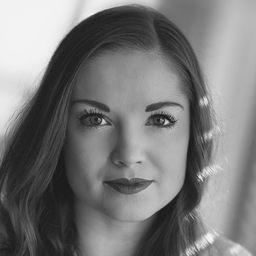

In [185]:
reference = convert2grayscale(data[2]['img'])
resized = transforms.Resize(
        256,
        # interpolation = PIL.Image.LANCZOS
        interpolation = transforms.functional.InterpolationMode.LANCZOS
    )(reference)
resized

In [132]:
PRETRAINED_MODEL = "stuff/pretrained_models/metfaces.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G2 = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module-
    G2.mapping.num_ws = 1 # setting to the space w not w+ that was defined by deafault

Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...
Saving last image...


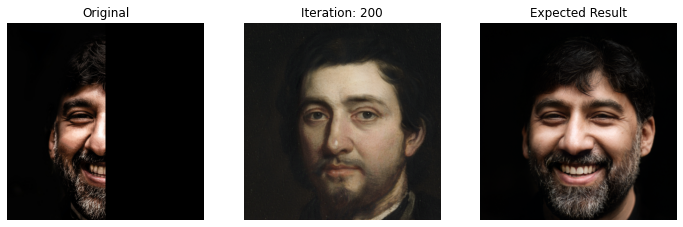

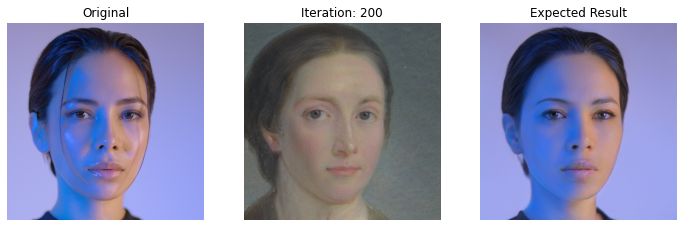

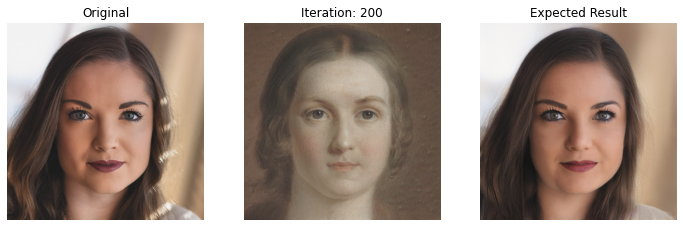

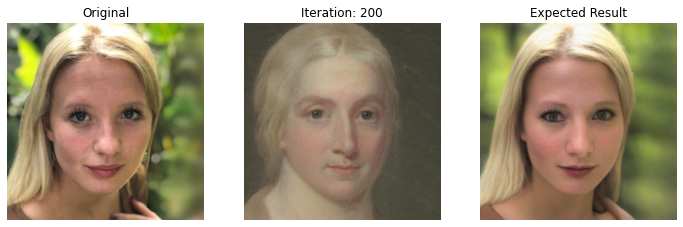

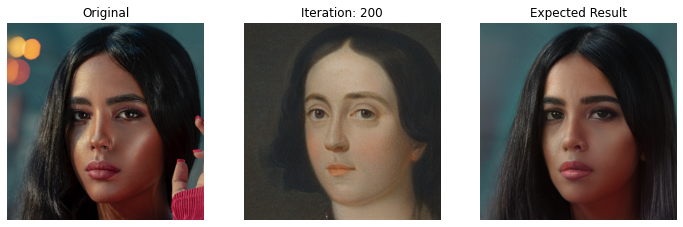

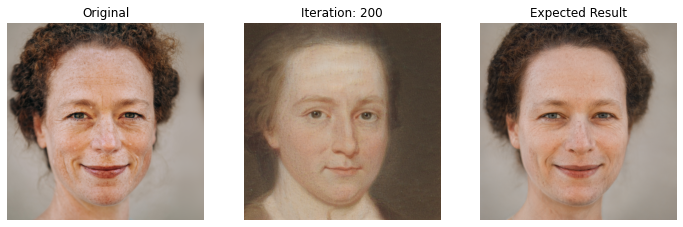

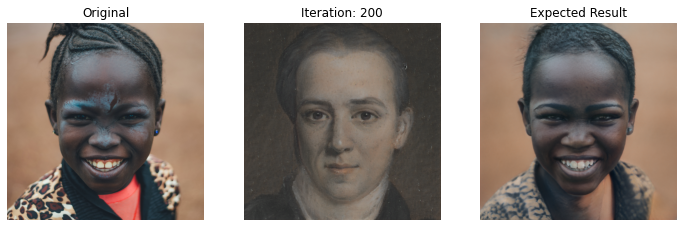

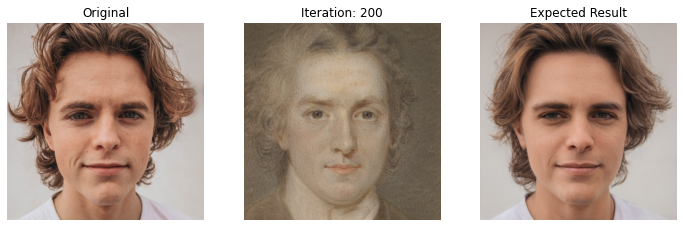

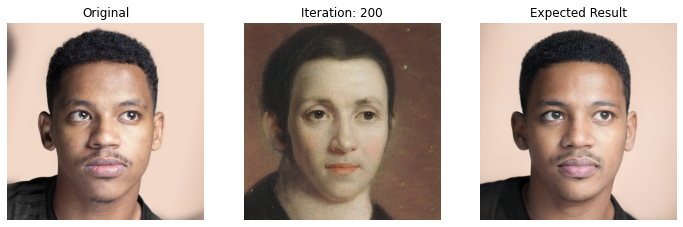

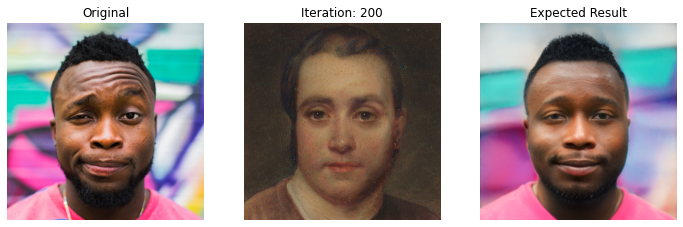

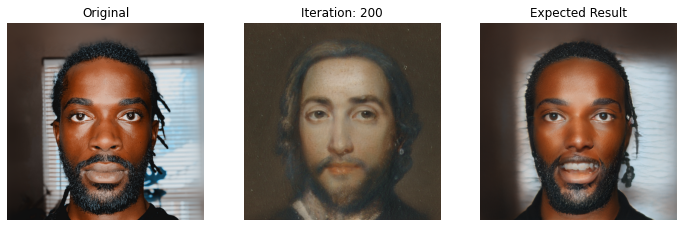

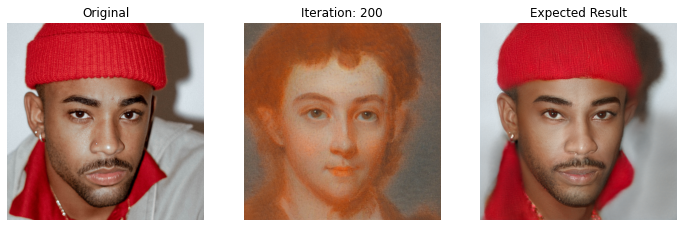

In [135]:
for i in range(len(aux_latents)):
    show_images_results(data, i, G2, aux_latents[i], [200],expected_result = True, save_last=True)

In [77]:
type(img_res.to("cuda:1"))

torch.Tensor

In [76]:
def generate_samples(num_samples, G, device):
    """Function to generate N samples in p-space.

    Args:
        num_samples ([int]): number of samples to be generated
        G           ([torch.Module]): pretrained generator module
        device      ([string]): string with the objective device

    Returns:
        [tensor]: tensor with N samples in p-space. Shape: [num_samples,512] 
    """
    # 1. Sampling 10e6 in Z space # what is the interval of z?
    X = torch.randn((int(num_samples), 512), device=device)
    print("z: ", X.size())

    # 2. Mappint z-space to w-space
    G.mapping.num_ws = 1   # setting to the space w not w+ that was defined by default
    X = G.mapping(X, None) # TODO: check what happend with truncation?

    # 2. Mapping w-space samples to p-space
    X = nn.LeakyReLU(negative_slope=5.0)(X).squeeze(1)
    print("p: ", X.size())

    return X.detach().cpu().numpy()

In [78]:
def apply_PCA(samples, n_components, device):
    pca = PCA(n_components=n_components)
    pca.fit(samples)
        
    components = torch.tensor(pca.components_.T).to(device)
    eigen_vals = torch.tensor(pca.explained_variance_).to(device)
    singular_vals = torch.tensor(pca.singular_values_).to(device)
    mean = torch.tensor(pca.mean_).to(device)
    
    return components, eigen_vals, mean, singular_vals

In [79]:
def get_PCA_results(G, device, n_components = 512, save = False, load = False):

  file_name = os.path.join(PCA_DIR,f"pca_results_n_components_{n_components}.npz")
    
  # Apply PCA
  if load:
    print("Loading: ", file_name)
    data = np.load(file_name)
    components = torch.tensor(data['eigen_vectors']).to(device)
    eigen_vals = torch.tensor(data['eigen_values']).to(device)
    mean = torch.tensor(data['mean']).to(device)
    singular_vals = torch.tensor(data['singulars']).to(device)

  else:
    # q are the used principal component
    X = generate_samples(1e6, G, device)
    components, eigen_vals, mean, singular_vals = apply_PCA(X, n_components, device)

  if save:
    print("Saving: ", file_name)
    np.savez(file_name, eigen_vectors = components.cpu().numpy(), 
                        eigen_values = eigen_vals.cpu().numpy(),
                        mean = mean.cpu().numpy(),
                        singulars = singular_vals.cpu().numpy())

  return components, eigen_vals, mean, singular_vals

In [81]:
components, eigen_vals, mean, singular_vals = get_PCA_results(G, DEVICE,load = True)

Loading:  stuff/data/pca/pca_results_n_components_512.npz


In [85]:
singular_vals

tensor([5.4749e+03, 5.0160e+03, 4.8192e+03, 4.7508e+03, 4.4190e+03, 4.2137e+03,
        4.0535e+03, 3.8893e+03, 3.2821e+03, 3.0933e+03, 2.8255e+03, 2.5408e+03,
        2.3731e+03, 2.2873e+03, 2.2215e+03, 2.1127e+03, 2.0031e+03, 1.9189e+03,
        1.7613e+03, 1.7017e+03, 1.6752e+03, 1.5946e+03, 1.5259e+03, 1.5041e+03,
        1.4436e+03, 1.4214e+03, 1.3922e+03, 1.3407e+03, 1.2922e+03, 1.2664e+03,
        1.2174e+03, 1.2117e+03, 1.1800e+03, 1.1600e+03, 1.1437e+03, 1.1153e+03,
        1.1079e+03, 1.0844e+03, 1.0598e+03, 1.0534e+03, 1.0428e+03, 1.0242e+03,
        1.0078e+03, 9.9916e+02, 9.8344e+02, 9.5978e+02, 9.5548e+02, 9.5372e+02,
        9.3095e+02, 9.2875e+02, 9.2267e+02, 9.1088e+02, 8.9176e+02, 8.7949e+02,
        8.7292e+02, 8.5579e+02, 8.5345e+02, 8.4681e+02, 8.3618e+02, 8.2651e+02,
        8.2233e+02, 8.1384e+02, 7.9780e+02, 7.9282e+02, 7.8849e+02, 7.6812e+02,
        7.5634e+02, 7.5218e+02, 7.4824e+02, 7.3991e+02, 7.3542e+02, 7.3190e+02,
        7.2335e+02, 7.2210e+02, 7.1109e+